# Task 2
This serves as a template which will guide you through the implementation of this task. It is advised to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps.
This is the jupyter notebook version of the template. For the python file version, please refer to the file `template_solution.py`.

First, we import necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Add any other imports you need here

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, Matern, RationalQuadratic, WhiteKernel, ExpSineSquared

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler, MatrixFactorization

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer


# Data Loading
TODO: Perform data preprocessing, imputation and extract X_train, y_train and X_test
(and potentially change initialization of variables to accomodate how you deal with non-numeric data)

In [3]:
"""
This loads the training and test data, preprocesses it, removes the NaN
values and interpolates the missing data using imputation

Parameters
----------
Compute
----------
X_train: matrix of floats, training input with features
y_train: array of floats, training output with labels
X_test: matrix of floats: dim = (100, ?), test input with features
"""
# Load training data
train_df = pd.read_csv("train.csv")
    
print("Training data:")
print("Shape:", train_df.shape)
print(train_df.head(2))
print('\n')
    
# Load test data
test_df = pd.read_csv("test.csv")

print("Test data:")
print(test_df.shape)
print(test_df.head(2))

# Dummy initialization of the X_train, X_test and y_train   
# TODO: Depending on how you deal with the non-numeric data, you may want to 
# modify/ignore the initialization of these variables   

X_train = np.zeros_like(train_df.drop(['price_CHF'],axis=1))
y_train = np.zeros_like(train_df['price_CHF'])
X_test = np.zeros_like(test_df)

# TODO: Perform data preprocessing, imputation and extract X_train, y_train and X_test
train_df['season']=train_df['season'].map({'spring':0.0, 'summer':1.0, 'autumn':2.0, 'winter':3.0})
test_df['season']=test_df['season'].map({'spring':0.0, 'summer':1.0, 'autumn':2.0, 'winter':3.0})

#knn:
#train_df_transposed = train_df.transpose()
#train_df_knn = KNN(k=4).fit_transform(train_df_transposed)
#train_df_knn = train_df_knn.transpose()

#test_df_transposed = test_df.transpose()
#test_df_knn = KNN(k=4).fit_transform(test_df_transposed)
#test_df_knn = test_df_knn.transpose()

#soft impute: 
train_df_si = SoftImpute().fit_transform(train_df_transposed)
train_df_si = train_df_si.transpose()

test_df_si = SoftImpute().fit_transform(test_df_transposed)
test_df_si = test_df_si.transpose()

#iterative imputer: 
it_imp = IterativeImputer(max_iter=10, random_state=0)

it_imp.fit(train_df)
train_df_it_imp = it_imp.transform(train_df)

it_imp.fit(test_df)
test_df_it_imp = it_imp.transform(test_df)

#matrix factorisation: 
mf = MatrixFactorization()
train_df_mf = mf.fit_transform(train_df)
test_df_mf = mf.fit_transform(test_df)

assert (X_train.shape[1] == X_test.shape[1]) and (X_train.shape[0] == y_train.shape[0]) and (X_test.shape[0] == 100), "Invalid data shape"

Training data:
Shape: (900, 11)
   season  price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
0  spring        NaN   9.644028  -1.686248  -1.748076  -3.666005        NaN   
1  summer        NaN   7.246061  -2.132377  -2.054363  -3.295697  -4.104759   

   price_UK  price_ITA  price_POL  price_SVK  
0 -1.822720  -3.931031        NaN  -3.238197  
1 -1.826021        NaN        NaN  -3.212894  


Test data:
(100, 10)
   season  price_AUS  price_CZE  price_GER  price_ESP  price_FRA  price_UK  \
0  spring        NaN   0.472985   0.707957        NaN  -1.136441 -0.596703   
1  summer  -1.184837   0.358019        NaN  -3.199028  -1.069695       NaN   

   price_ITA  price_POL  price_SVK  
0        NaN   3.298693   1.921886  
1  -1.420091   3.238307        NaN  
Imputing row 1/11 with 0 missing, elapsed time: 0.001
Imputing row 1/10 with 0 missing, elapsed time: 0.000
[SoftImpute] Max Singular Value of X_init = 192.336998
[SoftImpute] Iter 1: observed MAE=0.118422 rank=11
[SoftI

# Modeling and Prediction
TODO: Define the model and fit it using training data. Then, use test data to make predictions

In [8]:
"""
This defines the model, fits training data and then does the prediction
with the test data 

Parameters
----------
X_train: matrix of floats, training input with 10 features
y_train: array of floats, training output
X_test: matrix of floats: dim = (100, ?), test input with 10 features

Compute
----------
y_test: array of floats: dim = (100,), predictions on test set
"""

full_train = train_df_si #choose here one of: knn, si, it_imp or mf 
X_test = test_df_si #as above 

X_train = np.delete(full_train, 2, axis = 1) #deleting Switzerland
y_train = full_train[:, 2] #this is switzerland
y_pred=np.zeros(X_test.shape[0])


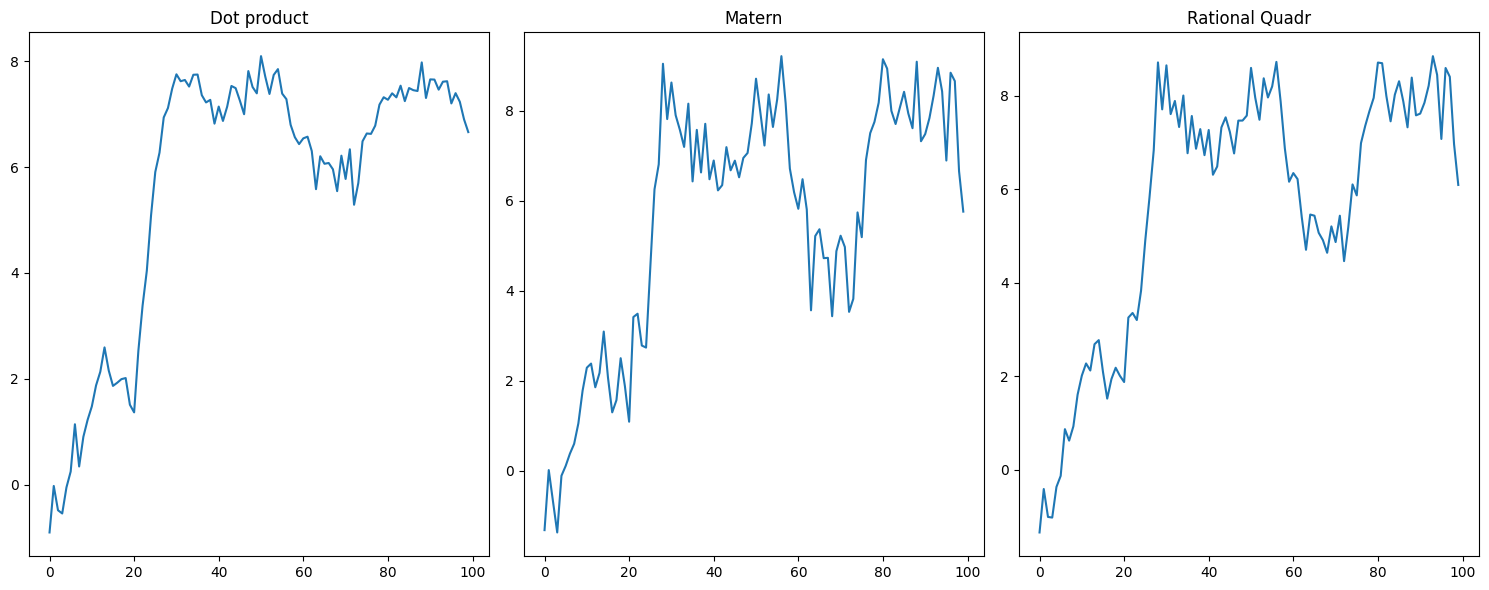

In [9]:

#TODO: Define the model and fit it using training data. Then, use test data to make predictions
gpr = GaussianProcessRegressor(kernel=DotProduct())
gpr.fit(X_train, y_train)
y_pred_dp = gpr.predict(X_test)

#RBF: matern is a generalization of RBF so maybe skip RBF? 
#gpr = GaussianProcessRegressor(kernel=RBF(length_scale=0.1))
#gpr.fit(X_train, y_train)
#y_pred_rbf = gpr.predict(X_test)

#Matern
gpr = GaussianProcessRegressor(kernel=Matern(length_scale=0.1))
gpr.fit(X_train, y_train)
y_pred_mat = gpr.predict(X_test)

#RationalQuadratic
gpr = GaussianProcessRegressor(kernel=RationalQuadratic())
gpr.fit(X_train, y_train)
y_pred_rq = gpr.predict(X_test)


#plotting 
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs = axs.flatten()

axs[0].plot(y_pred_dp)
axs[0].set_title('Dot product')
axs[1].plot(y_pred_mat)
axs[1].set_title('Matern')
axs[2].plot(y_pred_rq)
axs[2].set_title('Rational Quadr')


plt.tight_layout()
plt.show()

assert y_pred.shape == (100,), "Invalid data shape"



Text(0.5, 1.0, 'combination')

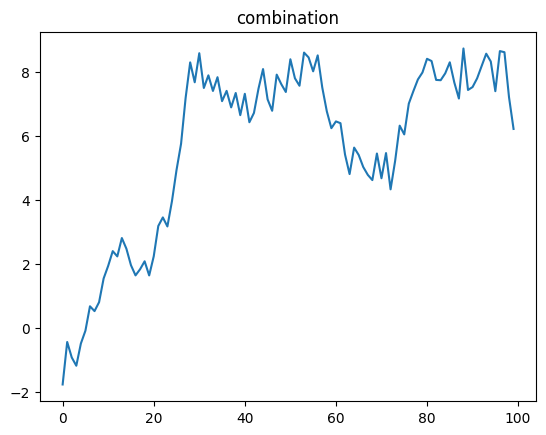

In [10]:
#my combination
gpr = GaussianProcessRegressor(kernel=RationalQuadratic()*DotProduct() + WhiteKernel())
gpr.fit(X_train, y_train)
y_pred_new = gpr.predict(X_test)

plt.plot(y_pred_new)
plt.title('combination')

Text(0.5, 1.0, 'winnie')

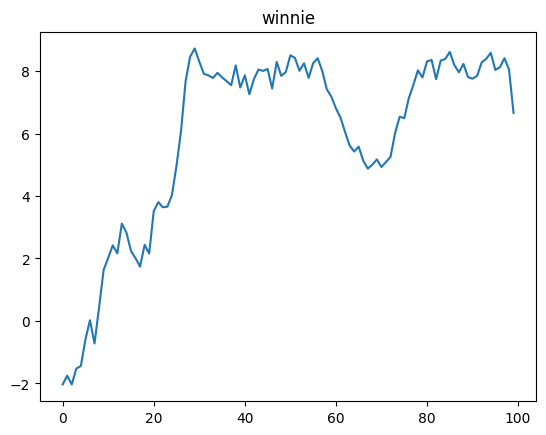

In [6]:
#winnie 
full_train = train_df_it_imp #choose here one of: knn, si, it_imp or mf 
X_test = test_df_it_imp #as above 

X_train = np.delete(full_train, 2, axis = 1) #deleting Switzerland
y_train = full_train[:, 2] #this is switzerland
y_pred=np.zeros(X_test.shape[0])

gpr = GaussianProcessRegressor(kernel=(RationalQuadratic()*Matern() + WhiteKernel())) 
gpr.fit(X_train, y_train)
y_winnie = gpr.predict(X_test)

plt.plot(y_winnie)
plt.title('winnie')

# Saving Results
You don't have to change this

In [11]:
dt = pd.DataFrame(y_pred_new) 
dt.columns = ['price_CHF']
dt.to_csv('results.csv', index=False)
print("\nResults file successfully generated!")


Results file successfully generated!
